In [25]:
# Import necessary libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import math

In [2]:
def load_images_from_directory(data_dir, img_size=64):
    X, y = [], []
    labels = sorted(os.listdir(data_dir))  # Sorted to ensure consistent mapping
    label_map = {label: idx for idx, label in enumerate(labels)}

    print(f"Loading images from: {data_dir}")
    for label in labels:
        path = os.path.join(data_dir, label)
        if not os.path.isdir(path):
            print(f"Skipping non-directory file: {path}")
            continue
        print(f"Processing class '{label}'...")
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip invalid formats
                print(f"Skipping non-image file: {img_path}")
                continue
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                print(f"Failed to read image: {img_path}")
                continue
            img = cv2.resize(img, (img_size, img_size)) / 255.0  # Normalize pixel values
            X.append(img)
            y.append(label_map[label])

    X = np.array(X, dtype="float32")
    y = to_categorical(np.array(y), num_classes=len(labels))  # One-hot encoding
    print(f"Loaded {len(X)} images from {data_dir}")
    return X, y, label_map


In [ ]:
# Import Dataset from Kaggel
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bapansardar/asl-datasets")

print("Path to dataset files:", path)

In [3]:
# Set dataset directories
train_dir = "dataset/asl_alphabet_train"
test_dir = "dataset/asl_alphabet_test"
img_size = 64

In [4]:
# Load training and testing datasets
X_train, y_train, label_map = load_images_from_directory(train_dir, img_size)
X_test, y_test, _ = load_images_from_directory(test_dir, img_size)

Loading images from: dataset/asl_alphabet_train
Processing class 'A'...
Processing class 'B'...
Processing class 'C'...
Processing class 'D'...
Processing class 'E'...
Processing class 'F'...
Processing class 'G'...
Processing class 'H'...
Processing class 'I'...
Processing class 'J'...
Processing class 'K'...
Processing class 'L'...
Processing class 'M'...
Processing class 'N'...
Processing class 'O'...
Processing class 'P'...
Processing class 'Q'...
Processing class 'R'...
Processing class 'S'...
Processing class 'T'...
Processing class 'U'...
Processing class 'V'...
Processing class 'W'...
Processing class 'X'...
Processing class 'Y'...
Processing class 'Z'...
Processing class 'del'...
Processing class 'nothing'...
Processing class 'space'...
Loaded 17839 images from dataset/asl_alphabet_train
Loading images from: dataset/asl_alphabet_test
Processing class 'A'...
Processing class 'B'...
Processing class 'C'...
Processing class 'D'...
Processing class 'E'...
Processing class 'F'...
P

In [5]:
# Print dataset stats
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Label map: {label_map}")

Training data shape: (17839, 64, 64, 3), Labels shape: (17839, 29)
Testing data shape: (17839, 64, 64, 3), Labels shape: (17839, 29)
Label map: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [7]:
# Enhanced Data Augmentation
datagen_train = ImageDataGenerator(
    rotation_range=30,  # Increase rotation range
    width_shift_range=0.3,  # Increase width shift
    height_shift_range=0.3,  # Increase height shift
    shear_range=0.2,  # Add shear
    zoom_range=0.3,  # Increase zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
# Define the model architecture (with MobileNetV2 as base)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(label_map), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/tmp/ipykernel_29491/1666957003.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
W0000 00:00:1737532833.529895   29491 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,593,373 (9.89 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Fine-tune MobileNetV2
base_model.trainable = True  # Unfreeze all layers of the base model

# Fine-tune from a certain layer to retain lower-level features
fine_tune_at = 100  # Unfreeze all layers from this point onward
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Modify Model Architecture: Add BatchNormalization and more layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Increased number of neurons
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(len(label_map), activation='softmax')(x)


In [11]:
# Callbacks for learning rate scheduling, early stopping, and model checkpointing
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

callbacks = [checkpoint, reduce_lr, early_stopping]


In [12]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # Reduce rotation
    width_shift_range=0.1,  # Slight adjustments
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


# Create the training and validation generators using data augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=32, subset='training')
val_generator = datagen.flow(X_train, y_train, batch_size=32, subset='validation')


In [13]:
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True


In [14]:
x = Dropout(0.6)(x)  # Increase dropout rate


In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)


In [16]:
batch_size = 16  # Try smaller batch size
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, subset='training')
val_generator = datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation')


In [17]:
# Get the class indices from the one-hot encoded labels
class_indices = np.argmax(y_train, axis=1)

# Compute weights for each class
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_indices),
    y=class_indices
)

# Convert the result to a dictionary
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 0.6151379310344828, 1: 2.1066367501180916, 2: 0.6151379310344828, 3: 0.6151379310344828, 4: 1.4108668142992724, 5: 1.0679477969348659, 6: 1.306025331283403, 7: 0.9953688204441469, 8: 1.185236861338117, 9: 1.3489866908650938, 10: 1.2377020745160618, 11: 1.1455082514608617, 12: 1.4012253554316236, 13: 1.2977593481740142, 14: 1.0018533078737504, 15: 0.6151379310344828, 16: 1.0868161325697576, 17: 0.6151379310344828, 18: 1.1898219168945507, 19: 0.6151379310344828, 20: 2.189102957418088, 21: 0.6238721410086032, 22: 1.4012253554316236, 23: 9.1811631497684, 24: 0.662150625440778, 25: 1.489438089671871, 26: 1.0252298850574713, 27: 0.6151379310344828, 28: 5.492302955665025}


In [18]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split for validation
)

# Define training and validation generators
train_generator = datagen.flow(X_train, y_train, batch_size=32, subset='training')
val_generator = datagen.flow(X_train, y_train, batch_size=32, subset='validation')


In [19]:
# Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train_split.shape}, Labels: {y_train_split.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")


Training data shape: (14271, 64, 64, 3), Labels: (14271, 29)
Validation data shape: (3568, 64, 64, 3), Labels: (3568, 29)


In [20]:
history = model.fit(
    X_train_split,  # Training features
    y_train_split,  # Training labels
    validation_data=(X_val, y_val),  # Validation data
    epochs=30,
    batch_size=32,
    class_weight=class_weights,  # Ensure class weights are defined properly
    callbacks=callbacks
)

Epoch 1/30
444/446 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4345 - loss: 2.2576
Epoch 1: val_loss improved from inf to 0.98154, saving model to best_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.4361 - loss: 2.2512 - val_accuracy: 0.7026 - val_loss: 0.9815 - learning_rate: 1.0000e-04
Epoch 2/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9270 - loss: 0.2587
Epoch 2: val_loss improved from 0.98154 to 0.23128, saving model to best_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9271 - loss: 0.2586 - val_accuracy: 0.9344 - val_loss: 0.2313 - learning_rate: 1.0000e-04
Epoch 3/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9676 - loss: 0.1204
Epoch 3: val_loss improved from 0.23128 to 0.05286, saving model to best_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9676 - loss: 0.1204 - val_accuracy: 0.9849 - val_loss: 0.0529 - learning_rate: 1.0000e-04
Epoch 4/30
445/446 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9843 - loss: 0.0576
Epoch 4: val_loss improved from 0.05286 to 0.03043, saving model to best_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9843 - loss: 0.0576 - val_accuracy: 0.9896 - val_loss: 0.0304 - learning_rate: 1.0000e-04
Epoch 5/30
445/446 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9818 - loss: 0.0854
Epoch 5: val_loss did not improve from 0.03043
446/446 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9818 - loss: 0.0853 - val_accuracy: 0.9916 - val_loss: 0.0367 - learning_rate: 1.0000e-04
Epoch 6/30
444/446 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9908 - loss: 0.0288
Epoch 6: val_loss improved from 0.03043 to 0.00949, saving model to best_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9908 - loss: 0.0288 - val_accuracy: 0.9978 - val_loss: 0.0095 - learning_rate: 1.0000e-04
Epoch 7/30
445/446 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9940 - loss: 0.0246
Epoch 7: val_loss improved from 0.00949 to 0.00830, saving model to best_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9940 - loss: 0.0246 - val_accuracy: 0.9980 - val_loss: 0.0083 - learning_rate: 1.0000e-04
Epoch 8/30
444/446 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9925 - loss: 0.0311
Epoch 8: val_loss did not improve from 0.00830
446/446 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9925 - loss: 0.0311 - val_accuracy: 0.9952 - val_loss: 0.0189 - learning_rate: 1.0000e-04
Epoch 9/30
445/446 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9955 - loss: 0.0163
Epoch 9: val_loss did not improve from 0.00830
446/446 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9955 - loss: 0.0163 - val_accuracy: 0.9983 - val_loss: 0.0086 - learning_rate: 1.0000e-04
Epoch 10/30
444/446 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9937 - loss: 0.0227
Epoch 10: val_loss did not improve from 0.00830

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
446/446 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9937 - loss: 0.0227 

446/446 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9972 - loss: 0.0137 - val_accuracy: 0.9992 - val_loss: 0.0052 - learning_rate: 5.0000e-05
Epoch 12/30
445/446 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9982 - loss: 0.0065
Epoch 12: val_loss did not improve from 0.00522
446/446 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.9986 - val_loss: 0.0068 - learning_rate: 5.0000e-05
Epoch 13/30
445/446 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9976 - loss: 0.0068
Epoch 13: val_loss did not improve from 0.00522
446/446 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9976 - loss: 0.0068 - val_accuracy: 0.9986 - val_loss: 0.0080 - learning_rate: 5.0000e-05
Epoch 14/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9984 - loss: 0.0064
Epoch 14: val_loss did not improve from 0.00522

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
446/446 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9984 - loss: 0.0

In [27]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
accuracy = math.floor(test_acc * 100)

print(f"Test Accuracy: {accuracy} %")

558/558 - 10s - 18ms/step - accuracy: 0.9998 - loss: 0.0011
Test Accuracy: 99 %


# Generate classification report and confusion matrix

In [28]:
# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_map.keys()))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

558/558 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1000
           B       1.00      1.00      1.00       292
           C       1.00      1.00      1.00      1000
           D       1.00      1.00      1.00      1000
           E       1.00      1.00      1.00       436
           F       1.00      1.00      1.00       576
           G       1.00      1.00      1.00       471
           H       1.00      1.00      1.00       618
           I       1.00      1.00      1.00       519
           J       1.00      1.00      1.00       456
           K       1.00      1.00      1.00       497
           L       1.00      1.00      1.00       537
           M       1.00      1.00      1.00       439
           N       1.00      1.00      1.00       474
           O       1.00      1.00      1.00       614
           P       1.00      1.00      1.00      1000
           Q  

In [29]:
# Function to predict a single image, display information, and show the image
def predict_sign(image_path, model, label_map, img_size=64):
    print("[INFO] Loading and preprocessing image...")
    
    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, (img_size, img_size)) / 255.0  # Normalize pixel values
    img_expanded = np.expand_dims(img_resized, axis=0)  # Add batch dimension

    # Predict the label
    prediction = model.predict(img_expanded)
    predicted_label_id = np.argmax(prediction)
    predicted_label = list(label_map.keys())[predicted_label_id]

    # Display detailed prediction information
    print("Prediction Probabilities:")
    for idx, (label, prob) in enumerate(zip(label_map.keys(), prediction[0])):
        print(f"ID: {idx}, Label: {label}, Probability: {prob * 100:.2f}%")
    
    print("\nFinal Decision:")
    print(".\n..\n...")
    print(f"ID: {predicted_label_id}, Label: {predicted_label}")

    # Show the image with its predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.title(f"Predicted Sign: {predicted_label}", fontsize=16, color='blue')
    plt.axis('off')
    plt.show()
    
    return predicted_label

In [30]:
# Save the trained model (optional)
model.save("asl_model.h5")

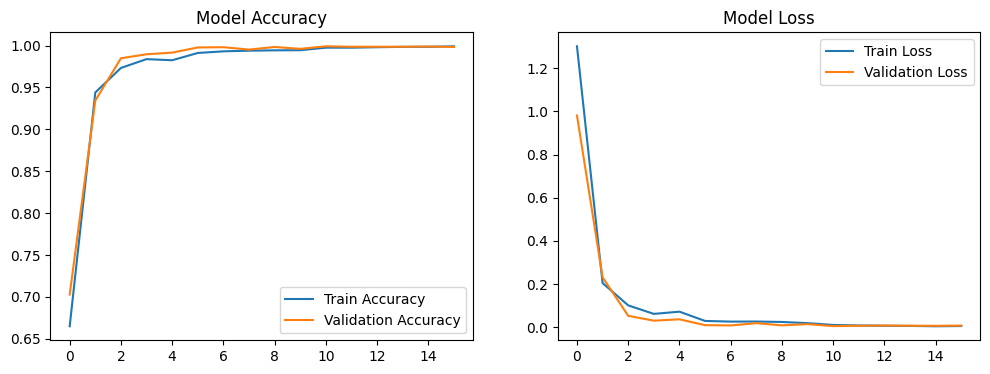

In [31]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 99.99%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label: 

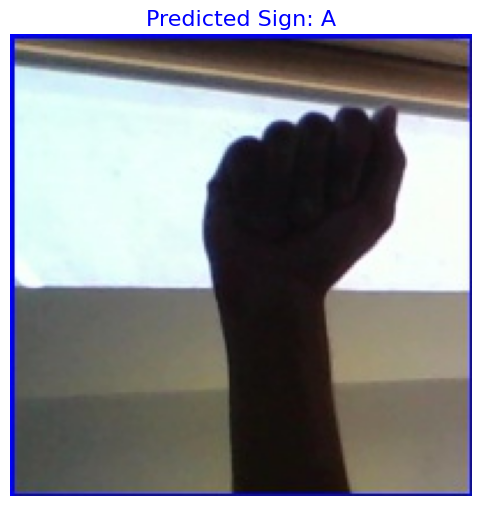

In [63]:
# Test the prediction function
test_image_path = "dataset/sample/A_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 100.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

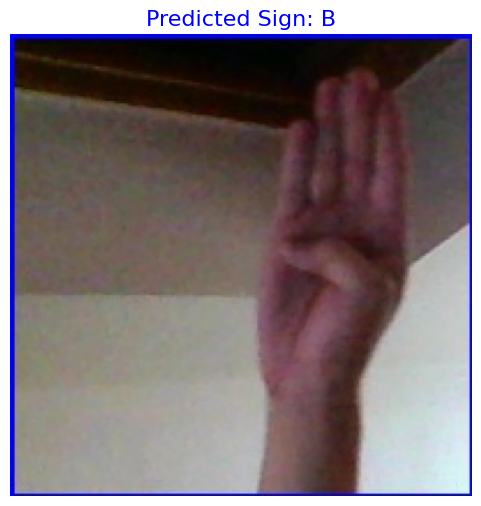

In [64]:
test_image_path = "dataset/sample/B2001.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 100.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

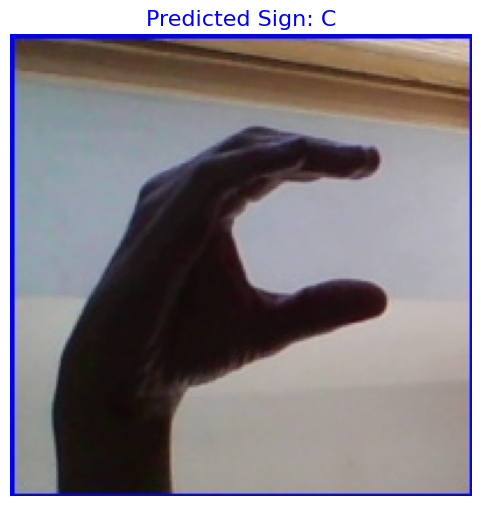

In [34]:
test_image_path = "dataset/sample/C_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 100.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

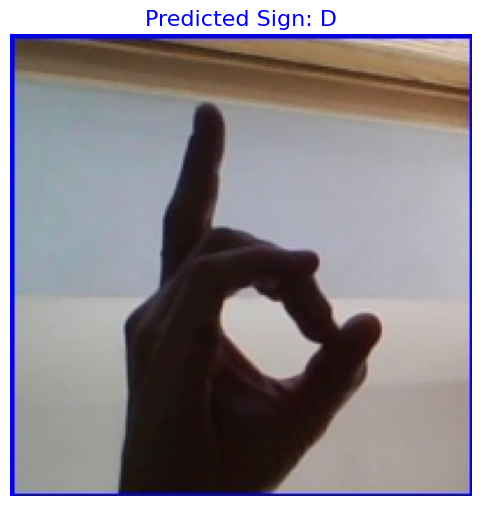

In [36]:
test_image_path = "dataset/sample/D_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label: Y

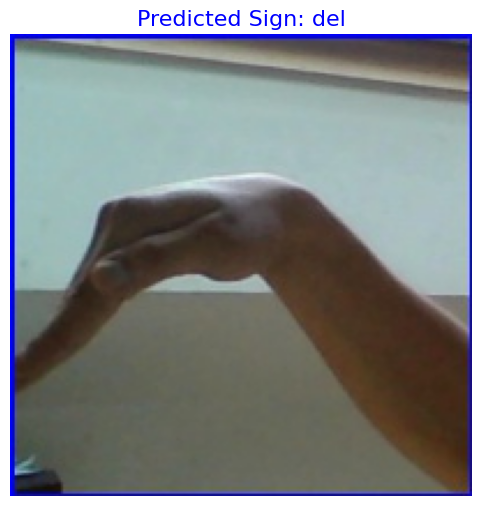

In [37]:
test_image_path = "dataset/sample/del_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 100.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

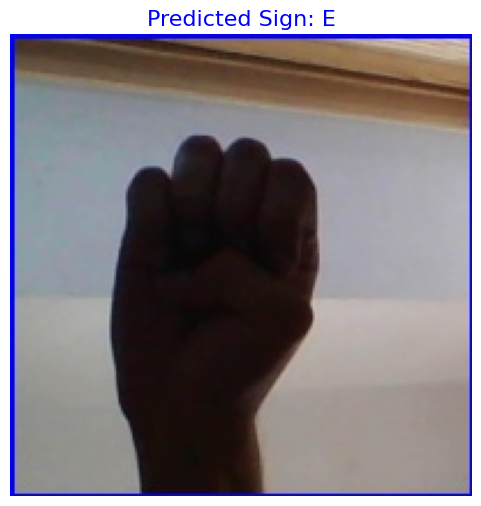

In [38]:
test_image_path = "dataset/sample/E_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 100.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

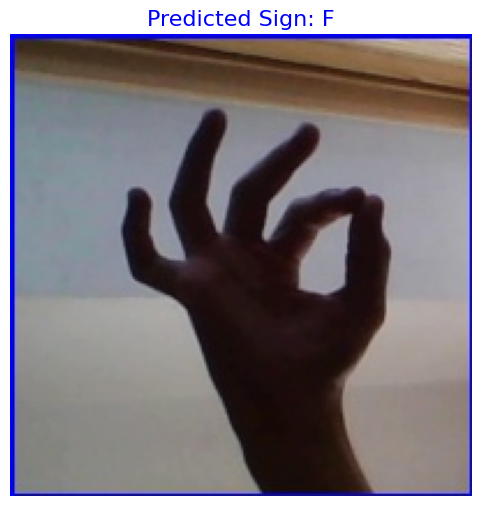

In [39]:
test_image_path = "dataset/sample/F_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 100.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

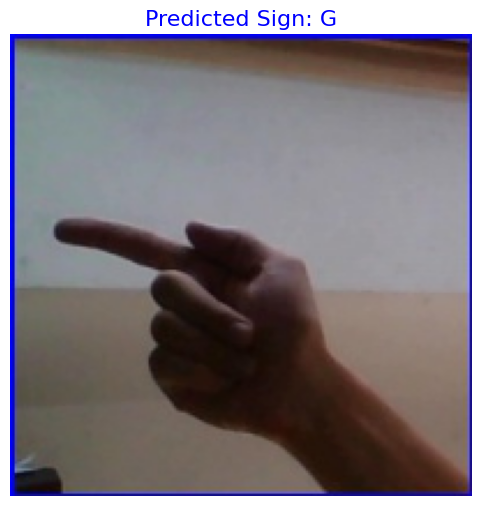

In [40]:
test_image_path = "dataset/sample/G_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 100.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

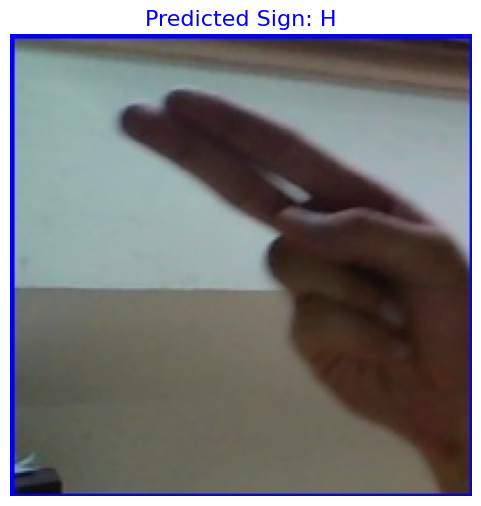

In [41]:
test_image_path = "dataset/sample/H_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 100.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

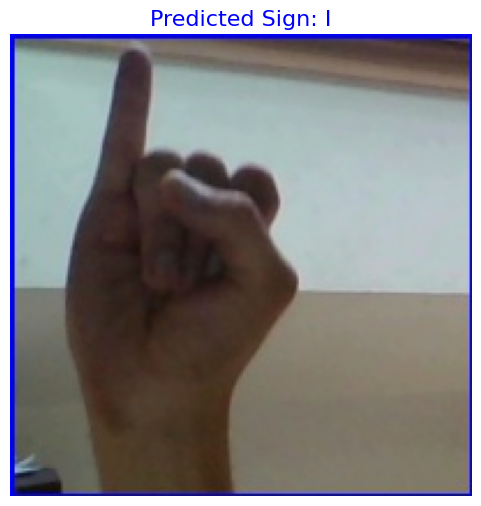

In [42]:
test_image_path = "dataset/sample/I_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 100.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

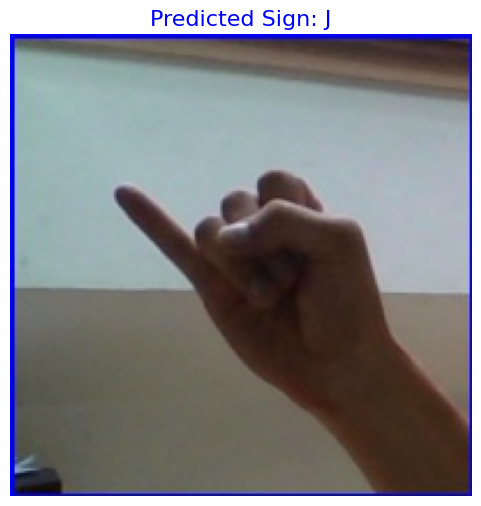

In [43]:
test_image_path = "dataset/sample/J_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 100.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

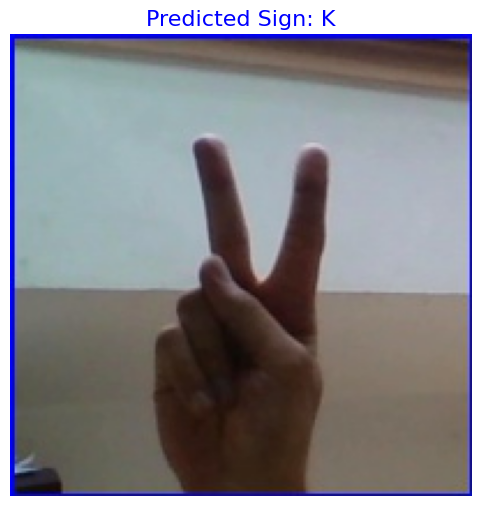

In [44]:
test_image_path = "dataset/sample/K_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 100.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

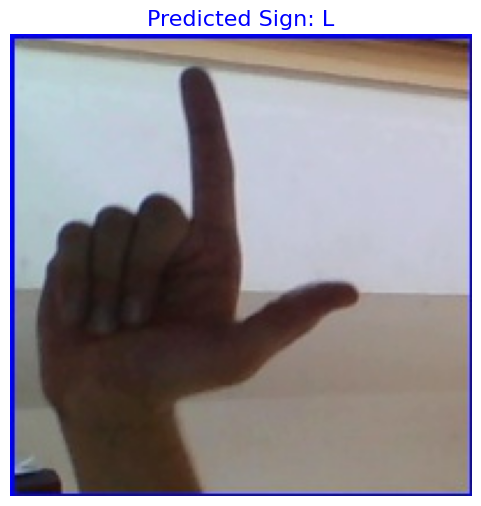

In [45]:
test_image_path = "dataset/sample/L_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 100.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

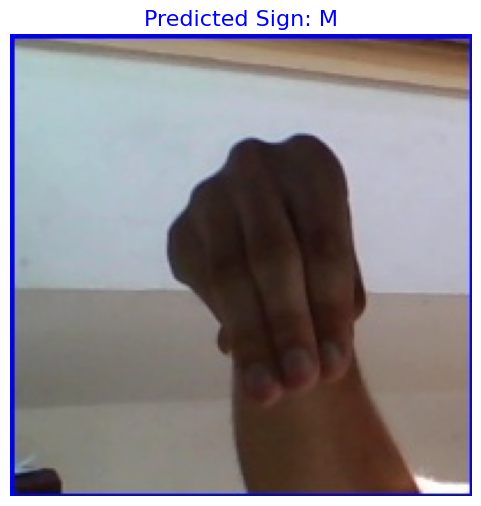

In [46]:
test_image_path = "dataset/sample/M_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 100.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

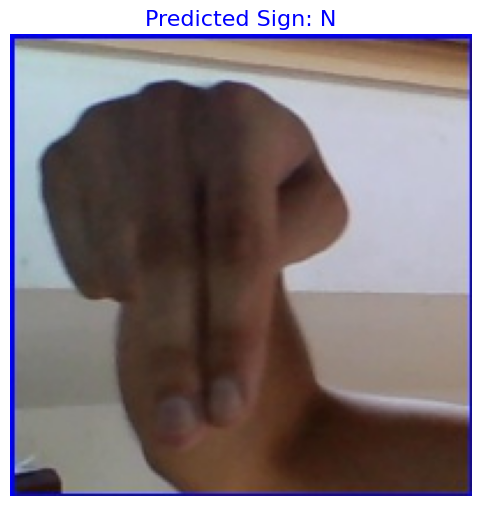

In [47]:
test_image_path = "dataset/sample/N_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label: Y

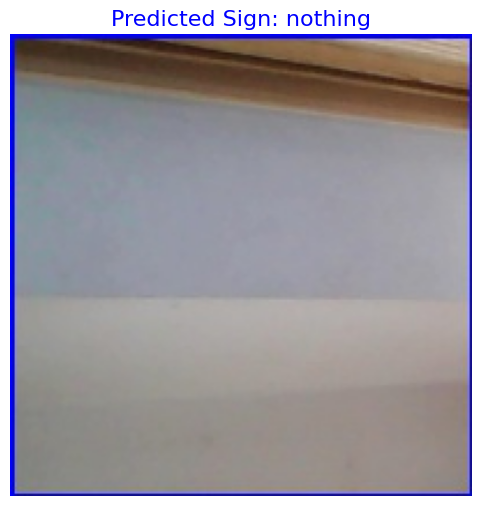

In [48]:
test_image_path = "dataset/sample/nothing_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 100.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

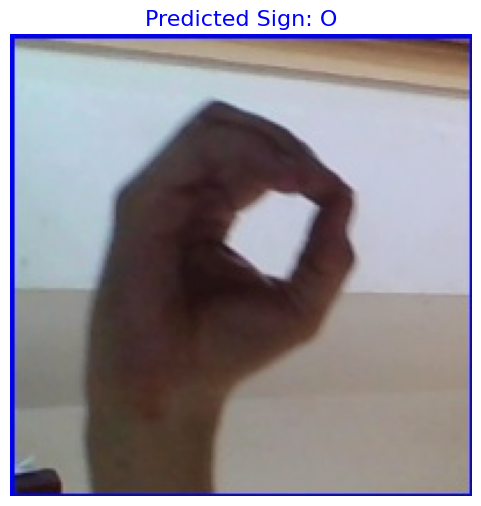

In [49]:
test_image_path = "dataset/sample/O_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 100.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

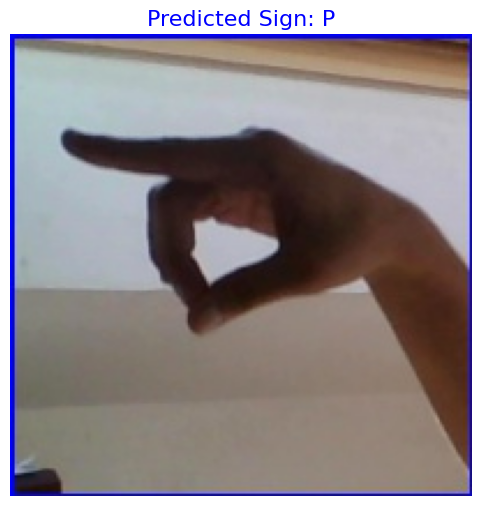

In [50]:
test_image_path = "dataset/sample/P_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 100.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

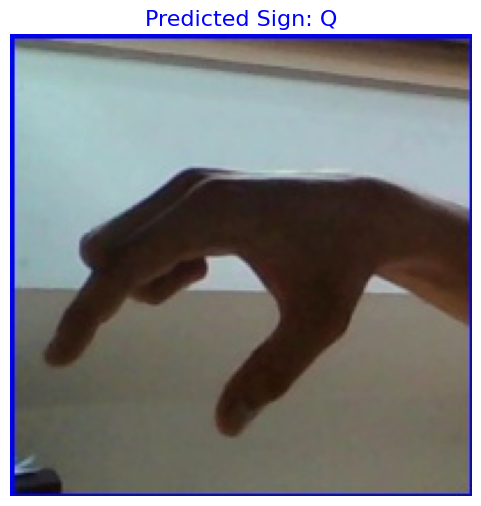

In [51]:
test_image_path = "dataset/sample/Q_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 100.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

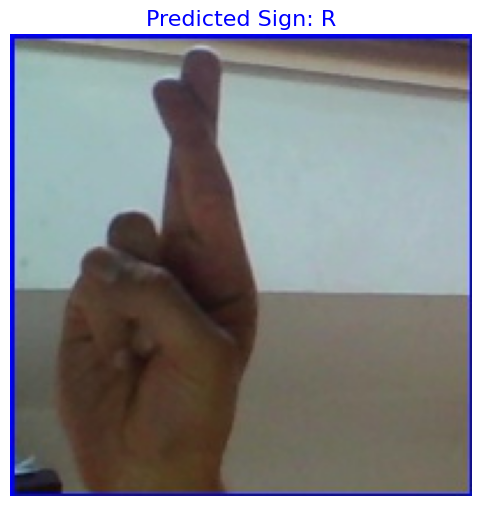

In [52]:
test_image_path = "dataset/sample/R_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 100.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

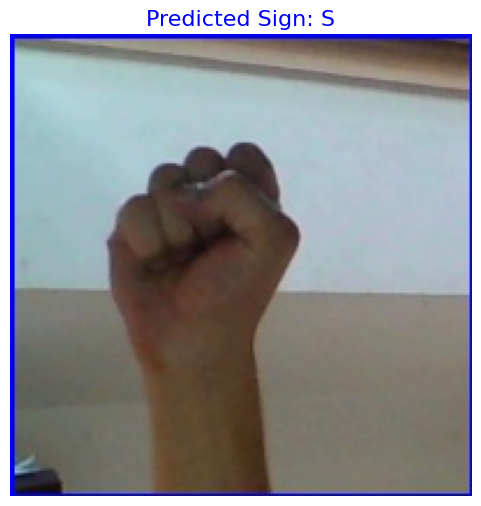

In [53]:
test_image_path = "dataset/sample/S_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label: Y

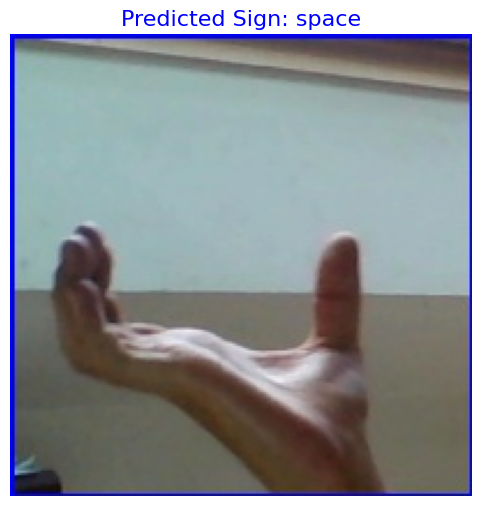

In [54]:
test_image_path = "dataset/sample/space_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 100.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

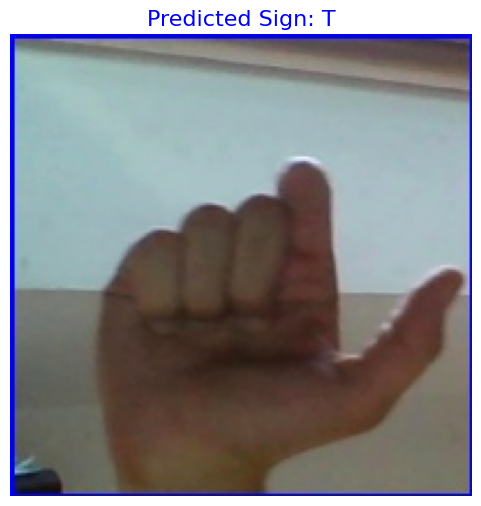

In [55]:
test_image_path = "dataset/sample/T_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 100.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

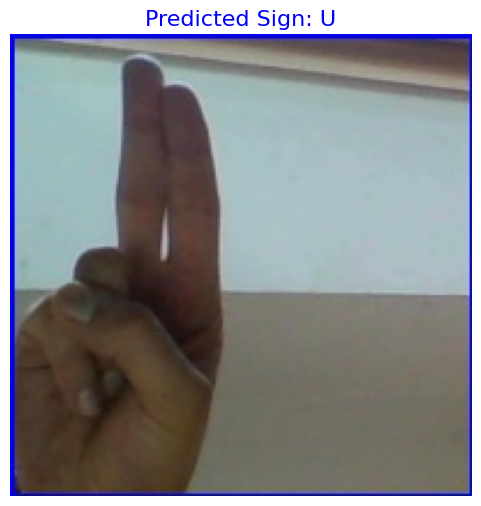

In [56]:
test_image_path = "dataset/sample/U_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 100.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

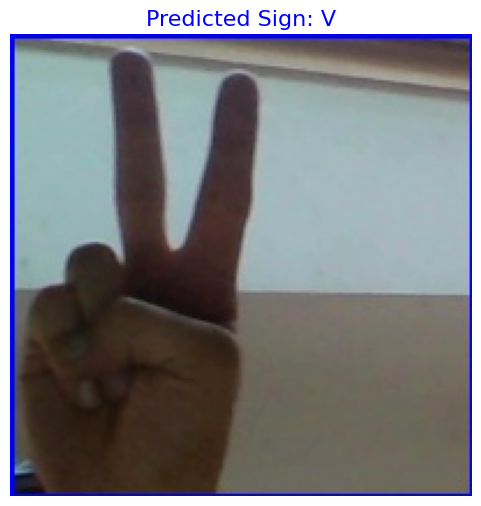

In [57]:
test_image_path = "dataset/sample/V_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 100.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label:

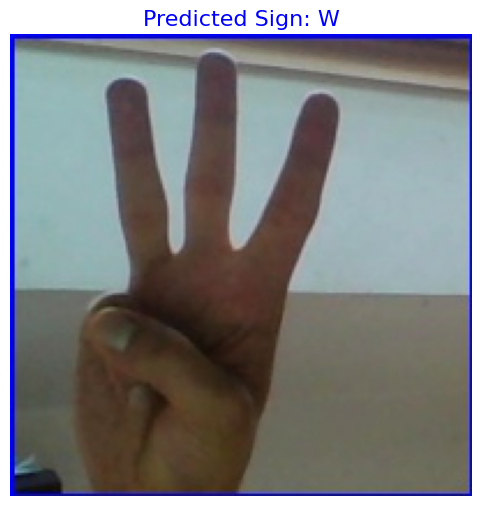

In [58]:
test_image_path = "dataset/sample/W_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 100.00%
ID: 24, Label:

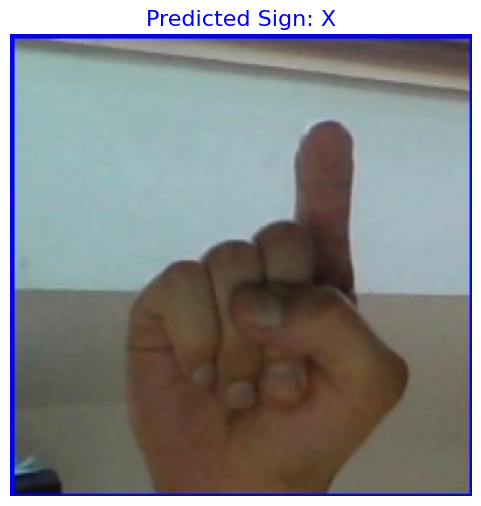

In [59]:
test_image_path = "dataset/sample/X_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.01%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label: Y

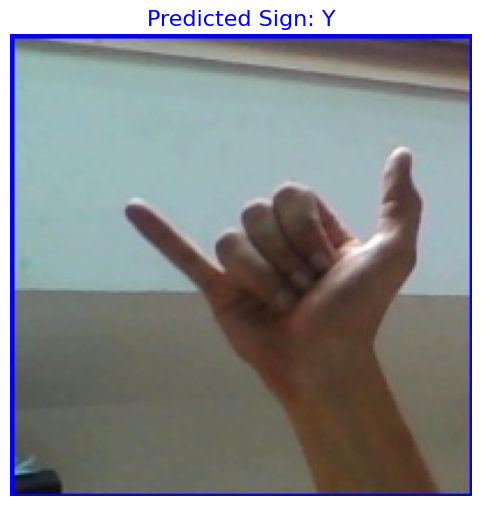

In [60]:
test_image_path = "dataset/sample/Y_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)

[INFO] Loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction Probabilities:
ID: 0, Label: A, Probability: 0.00%
ID: 1, Label: B, Probability: 0.00%
ID: 2, Label: C, Probability: 0.00%
ID: 3, Label: D, Probability: 0.00%
ID: 4, Label: E, Probability: 0.00%
ID: 5, Label: F, Probability: 0.00%
ID: 6, Label: G, Probability: 0.00%
ID: 7, Label: H, Probability: 0.00%
ID: 8, Label: I, Probability: 0.00%
ID: 9, Label: J, Probability: 0.00%
ID: 10, Label: K, Probability: 0.00%
ID: 11, Label: L, Probability: 0.00%
ID: 12, Label: M, Probability: 0.00%
ID: 13, Label: N, Probability: 0.00%
ID: 14, Label: O, Probability: 0.00%
ID: 15, Label: P, Probability: 0.00%
ID: 16, Label: Q, Probability: 0.00%
ID: 17, Label: R, Probability: 0.00%
ID: 18, Label: S, Probability: 0.00%
ID: 19, Label: T, Probability: 0.00%
ID: 20, Label: U, Probability: 0.00%
ID: 21, Label: V, Probability: 0.00%
ID: 22, Label: W, Probability: 0.00%
ID: 23, Label: X, Probability: 0.00%
ID: 24, Label: Y

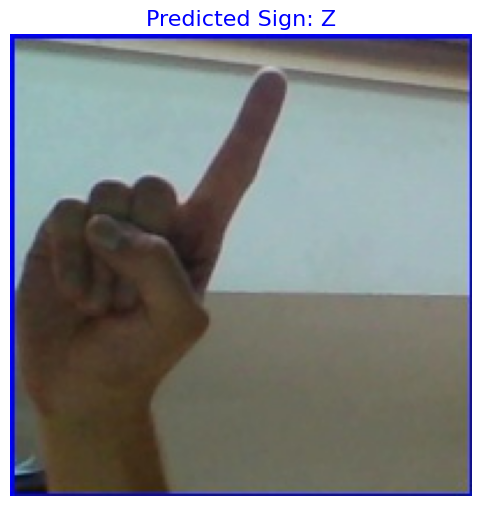

In [62]:
test_image_path = "dataset/sample/Z_test.jpg"
predicted_sign = predict_sign(test_image_path, model, label_map)